Simulations for bottleneck grant

### Functions for generating task sequences

In [1]:
import pandas as pd
import numpy as np 

def generate_urn_sequence(N=1000, p0=0.1, p1=0.9, h=0.1, start_urn=None):

    # Urn sequence
    urn_sequence = np.zeros(N, dtype=bool)
    if start_urn is None:
        urn_sequence[0] = np.random.binomial(1, 0.5)==1
    for i, f in enumerate(np.random.binomial(1, h, size=N-1)):
        urn_sequence[i+1] = ~urn_sequence[i] if f==1 else urn_sequence[i]

    # Bead sequence
    bead_sequence = np.zeros(N, dtype=bool)
    bead_sequence[~urn_sequence] = np.random.binomial(1, p0, size=np.count_nonzero(~urn_sequence))==1
    bead_sequence[urn_sequence] = np.random.binomial(1, p1, size=np.count_nonzero(urn_sequence))==1

    # Return the sequences as dataframe
    return pd.DataFrame({'urn' : urn_sequence, 'bead' : bead_sequence})


### Functions for simulating decision-making agents

In [2]:
# Normative agent (Glaze et al 215)
def normative_choice_agent(beads, p0, p1, h, noise=0.1):

    LLRs = np.log(p1/p0)*np.ones(len(beads))
    LLRs[~beads] = np.log((1-p1)/(1-p0)) #*np.ones(np.count_nonzero(~beads))
    beliefs = np.zeros(len(beads))
    beliefs[0] = LLRs[0]
    hv = (1-h)/h

    # Compute belief (L) as log-prior-odds
    for i, LLR in enumerate(LLRs[1:]):
        beliefs[i+1] = LLR + beliefs[i] + np.log(hv + np.exp(-beliefs[i])) - np.log(hv + np.exp(beliefs[i]))
    
    # generate choices
    choices = np.random.binomial(1, 1/(1 + np.exp(-beliefs/noise)))==1

    # Return the beliefs and choices as dataframe
    return pd.DataFrame({'na_belief' : beliefs, 'na_choice' : choices})


### Utility functions from Alex for computing MI for different window sizes

In [128]:
import ndd

# Get windowed sequence
def get_windowed_xs(x,z,w=1):
    xc = np.array(x.copy())
    zw = z[w:].copy()
    aux_base = 2**np.arange(w)
    xw_binned = np.array([np.inner(xc[i:i+w], aux_base) for i in np.arange(len(zw))]).astype(int)
    return(xw_binned, zw)

# Calculate mutual information using NSB method    
def mutual_inf_nsb(x, y, ks):
    ar = np.column_stack((x, y))
    mi = ndd.mutual_information(ar, ks)
    return np.log2(np.e)*mi # ndd returns nats - multiply by log2(e) to convert to bits

# Compute i_past vs i_future from empirical data
#   x is observations
#   y is ground truth
#   z is responses (choices)
#   w is window size of i_past
def get_i_past_future(x, y, z, w):
    x_w, z_w = get_windowed_xs(x, z, w)
    i_past = mutual_inf_nsb(x_w, z_w, [2**w,2])
    i_future = mutual_inf_nsb(z, y, [2,2])
    return(i_past, i_future)

### Compute IB

Use simulated normative agent and compute IB using embo and ndd. They return different values for i_past

In [62]:
from embo import InformationBottleneck as IB

# Simulate normative agent
N = 10000
p0 = 0.2
p1 = 1-p0
h  = 0.05
max_win_size = 10
noise = 0.01
us = generate_urn_sequence(N, p0, p1, h)
cs = normative_choice_agent(us['bead'], p0, p1, h, noise)
df = pd.concat([us, cs], axis=1)

beads = us['bead'].astype(int)
urns = us['urn'].astype(int)
choices = cs['na_choice'].astype(int)
w=8

(ip1, if1) = get_i_past_future(beads, urns, choices, w)
ip2 = IB(beads, choices, window_size_x=w, window_size_y=1).get_saturation_point()
if2 = IB(choices, urns, window_size_x=1, window_size_y=1).get_saturation_point()

print(f'ipast:   1={ip1:.3f}, 2={ip2:.3f}')
print(f'ifuture: 1={if1:.3f}, 2={if2:.3f}')


ipast:   1=0.680, 2=0.973
ifuture: 1=0.451, 2=0.451


In [71]:
adat_trials = pd.read_csv("./Urn-Confidence/Pilot/adat_trials_test.csv")

In [136]:
adat_trials

,Unnamed: 0,Subject,Trial,Jar,Bead,Response,Confidence,Correct,History
0,1000,5d6f,10,0,0,0,0,1,0
1,1001,5d6f,11,0,0,0,1,1,0
2,1002,5d6f,12,0,0,0,1,1,0
3,1003,5d6f,13,0,0,0,1,1,0
4,1004,5d6f,14,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
995,1995,5d6f,1005,1,1,1,0,1,101111111
996,1996,5d6f,1006,1,0,1,0,0,1011111111
997,1997,5d6f,1007,1,0,1,1,0,111111110
998,1998,5d6f,1008,1,0,1,0,0,1111111100


In [84]:
beads = adat_trials['Bead']
choices = adat_trials['Response']
urns = adat_trials['Jar']

In [135]:
IB(choices,urns,window_size_x=1,window_size_y=1).get_saturation_point()

0.333827175038625

In [112]:
IB(beads,choices,window_size_x=6,window_size_y=1).get_saturation_point()

0.5565324083053209

In [134]:
(ip1, if1) = get_i_past_future(beads, urns, choices, 10)
if1

0.3312475214245512

In [119]:
(ip1, if1) = get_i_past_future(beads, urns, choices, w)
ip2 = IB(beads, choices, window_size_x=w, window_size_y=1).get_saturation_point()
if2 = IB(choices, urns, window_size_x=1, window_size_y=1).get_saturation_point()

print(f'ipast:   1={ip1:.3f}, 2={ip2:.3f}')
print(f'ifuture: 1={if1:.3f}, 2={if2:.3f}')

ipast:   1=0.572, 2=nan
ifuture: 1=0.331, 2=0.334


In [58]:
get_windowed_xs(beads,choices,w=1)

(array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

### Bounds computed using embo and using the windowing utility

I also was surprised that this gave different answers. I thought I convinced myself that the windowing was the same in embo and in the utility, but maybe not?

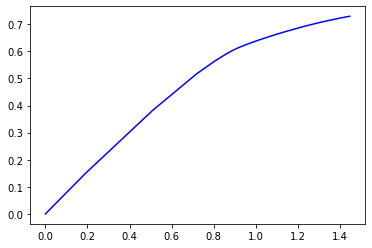

In [114]:
from matplotlib import pyplot as plt

# Compute using built-in windowing
I_x, I_y, _, _ = IB(beads, urns, window_size_x=w, window_size_y=1).get_bottleneck()

# Compute after windowing
(beads_w, urns_w) = get_windowed_xs(beads, urns, w)
I_x_w, I_y_w, _, _ = IB(beads_w, urns_w, window_size_x=1, window_size_y=1).get_bottleneck()

plt.plot(I_x,  I_y,  'r-')
plt.plot(I_x_w, I_y_w, 'b-')
plt.show()



In [118]:
I_x_w, I_y_w


(array([1.69326770e-12, 1.15588419e-07, 1.39389715e-05, 5.00751373e-04,
        5.52742031e-03, 1.90914090e-01, 5.08609920e-01, 7.20001176e-01,
        8.07445845e-01, 8.57530410e-01, 8.89814676e-01, 9.14487745e-01,
        9.40461113e-01, 9.71917176e-01, 1.00798847e+00, 1.04532119e+00,
        1.08374928e+00, 1.11338709e+00, 1.14706841e+00, 1.17664999e+00,
        1.21219655e+00, 1.24918695e+00, 1.27912293e+00, 1.31199541e+00,
        1.33843833e+00, 1.36307587e+00, 1.38646628e+00, 1.40826649e+00,
        1.42847648e+00, 1.44786181e+00]),
 array([1.35947698e-12, 9.28016685e-08, 1.11910728e-05, 4.02009852e-04,
        4.43490606e-03, 1.49824747e-01, 3.80933292e-01, 5.17217974e-01,
        5.64965772e-01, 5.89073909e-01, 6.02797166e-01, 6.11978405e-01,
        6.20350904e-01, 6.29613218e-01, 6.39607445e-01, 6.49366742e-01,
        6.58878576e-01, 6.66065967e-01, 6.73776368e-01, 6.80279655e-01,
        6.88003174e-01, 6.95628881e-01, 7.01375515e-01, 7.07557419e-01,
        7.12174444e-01